# **Linear Models in TensorFlow: Timing Factors and Smart-Beta Strategies** 

**Project Goal**: To build a neural network, under linear models, that aims to predict the future returns of the momentum factor.

**Data Source**

- We are gping to take as inputs the returns from a momentum factor. Using these inputs, we will then aim to predict next period momentum factor returns using as inputs past returns. 

- Data source is Prof. Ken French's Data Library: [Daily returns of 10 Portfolios Formed Daily on Momentum.](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_10_port_form_pr_12_2_daily.html)

In [20]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

**Timing Momentum with (Linear Regression) Neural Networks**

In [21]:
route = "10_Portfolios_Prior_12_2_Daily.CSV"
# Read the csv file again with skipped rows
df = pd.read_csv(route, index_col=0)
# Format the date index
df.index = pd.to_datetime(df.index, format="%Y%m%d")
# Build the MOM strategy: Long "Hi PRIOR" and Short "Lo PRIOR"
df["Mom"] = df["Hi PRIOR"] - df["Lo PRIOR"]
df.head()

,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR,Mom
1926-11-03,-0.12,0.60,-0.09,0.30,-0.51,-0.22,-0.12,0.50,0.13,1.28,1.40
1926-11-04,0.65,1.82,1.34,0.61,1.01,0.64,0.82,0.44,0.48,0.40,-0.25
1926-11-05,-0.84,-0.77,-0.22,-0.15,-0.02,-0.02,-0.07,0.36,0.20,0.08,0.92
1926-11-06,1.03,0.28,0.24,0.40,0.19,0.64,0.10,0.10,0.39,-0.68,-1.71
1926-11-08,-0.06,0.11,1.78,0.28,0.36,0.23,0.30,1.17,0.58,-0.18,-0.12


**Inputs and Outputs**

In [22]:
df["Ret"] = df["Mom"]
df["Ret10_MOMi"] = df["Mom"].rolling(10).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret25_MOMi"] = df["Mom"].rolling(25).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret60_MOMi"] = df["Mom"].rolling(60).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret120_MOMi"] = df["Mom"].rolling(120).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret240_MOMi"] = df["Mom"].rolling(240).apply(lambda x: np.prod(1 + x / 100) - 1)

df["Ret10_hi"] = df["Hi PRIOR"].rolling(10).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret25_hi"] = df["Hi PRIOR"].rolling(25).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret60_hi"] = df["Hi PRIOR"].rolling(60).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret120_hi"] = df["Hi PRIOR"].rolling(120).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret240_hi"] = df["Hi PRIOR"].rolling(240).apply(lambda x: np.prod(1 + x / 100) - 1)

df["Ret10_Low"] = df["Lo PRIOR"].rolling(10).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret25_Low"] = df["Lo PRIOR"].rolling(25).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret60_Low"] = df["Lo PRIOR"].rolling(60).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret120_Low"] = df["Lo PRIOR"].rolling(120).apply(lambda x: np.prod(1 + x / 100) - 1)
df["Ret240_Low"] = df["Lo PRIOR"].rolling(240).apply(lambda x: np.prod(1 + x / 100) - 1)

df["Ret60"] = df["Ret60_MOMi"].shift(-60)
df = df.dropna()
df.tail(10)

df = df.drop(
    [
        "Lo PRIOR",
        "PRIOR 2",
        "PRIOR 3",
        "PRIOR 4",
        "PRIOR 5",
        "PRIOR 6",
        "PRIOR 7",
        "PRIOR 8",
        "PRIOR 9",
        "Hi PRIOR",
        "Mom",
    ],
    axis=1,
)

In [23]:
df.head()

,Ret,Ret10_MOMi,Ret25_MOMi,Ret60_MOMi,Ret120_MOMi,Ret240_MOMi,Ret10_hi,Ret25_hi,Ret60_hi,Ret120_hi,Ret240_hi,Ret10_Low,Ret25_Low,Ret60_Low,Ret120_Low,Ret240_Low,Ret60
1927-08-19,1.60,-0.007189,-0.011632,0.029566,0.201590,0.275852,-0.003897,0.010958,0.031462,0.181792,0.458303,0.003376,0.021960,-0.000112,-0.021026,0.125174,0.102616
1927-08-20,0.74,-0.016077,-0.002022,0.028443,0.191185,0.267548,-0.006644,0.027704,0.043832,0.192865,0.458015,0.009704,0.028920,0.013091,-0.002974,0.132384,0.087730
1927-08-22,0.71,-0.008596,0.002957,0.033884,0.216675,0.279747,-0.002775,0.025256,0.054955,0.209346,0.459903,0.005975,0.021349,0.018498,-0.010311,0.123046,0.081898
1927-08-23,0.97,0.033152,0.008149,0.038926,0.213431,0.280381,0.031562,0.018638,0.056751,0.207897,0.459320,-0.001583,0.009427,0.015219,-0.008810,0.122026,0.040216
1927-08-24,0.91,0.061988,0.007949,0.066728,0.225576,0.314510,0.070620,0.015491,0.086507,0.208018,0.470046,0.007666,0.006483,0.016347,-0.018610,0.101036,0.036711


**Train Test Split**

In [24]:
df.reset_index(inplace=True)
df.rename(columns={"index": "Date"}, inplace=True)
df.head()

,Date,Ret,Ret10_MOMi,Ret25_MOMi,Ret60_MOMi,Ret120_MOMi,Ret240_MOMi,Ret10_hi,Ret25_hi,Ret60_hi,Ret120_hi,Ret240_hi,Ret10_Low,Ret25_Low,Ret60_Low,Ret120_Low,Ret240_Low,Ret60
0,1927-08-19,1.60,-0.007189,-0.011632,0.029566,0.201590,0.275852,-0.003897,0.010958,0.031462,0.181792,0.458303,0.003376,0.021960,-0.000112,-0.021026,0.125174,0.102616
1,1927-08-20,0.74,-0.016077,-0.002022,0.028443,0.191185,0.267548,-0.006644,0.027704,0.043832,0.192865,0.458015,0.009704,0.028920,0.013091,-0.002974,0.132384,0.087730
2,1927-08-22,0.71,-0.008596,0.002957,0.033884,0.216675,0.279747,-0.002775,0.025256,0.054955,0.209346,0.459903,0.005975,0.021349,0.018498,-0.010311,0.123046,0.081898
3,1927-08-23,0.97,0.033152,0.008149,0.038926,0.213431,0.280381,0.031562,0.018638,0.056751,0.207897,0.459320,-0.001583,0.009427,0.015219,-0.008810,0.122026,0.040216
4,1927-08-24,0.91,0.061988,0.007949,0.066728,0.225576,0.314510,0.070620,0.015491,0.086507,0.208018,0.470046,0.007666,0.006483,0.016347,-0.018610,0.101036,0.036711


In [25]:
df.reset_index(inplace=True, drop=True)

ts = int(0.4 * len(df))
split_time = len(df) - ts
test_time = df.iloc[split_time:, 0:1].values
Ret_vector = df.iloc[split_time:, 1:2].values
df.tail()

,Date,Ret,Ret10_MOMi,Ret25_MOMi,Ret60_MOMi,Ret120_MOMi,Ret240_MOMi,Ret10_hi,Ret25_hi,Ret60_hi,Ret120_hi,Ret240_hi,Ret10_Low,Ret25_Low,Ret60_Low,Ret120_Low,Ret240_Low,Ret60
25475,2024-08-29,-4.21,-0.035453,0.063937,-0.114656,-0.021273,0.182380,-0.034336,0.038463,0.002863,0.112082,0.463052,0.001078,-0.023261,0.124712,0.119166,0.183476,0.117438
25476,2024-08-30,0.88,-0.026478,0.078585,-0.125749,0.016932,0.172962,-0.022781,0.041748,-0.018133,0.147941,0.483963,0.003772,-0.033350,0.114849,0.112311,0.210427,0.059617
25477,2024-09-03,-2.00,-0.056702,0.062432,-0.133705,-0.043668,0.150308,-0.101268,-0.013252,-0.069597,0.046629,0.397170,-0.046576,-0.069687,0.067058,0.079807,0.163062,0.098866
25478,2024-09-04,0.49,-0.048273,0.106131,-0.140717,-0.033861,0.162805,-0.093159,0.019845,-0.073135,0.047156,0.412210,-0.046576,-0.076586,0.071820,0.069334,0.162827,0.075027
25479,2024-09-05,0.18,-0.049032,0.051948,-0.157206,-0.045109,0.168755,-0.101854,-0.034501,-0.084556,0.059955,0.449385,-0.054984,-0.080997,0.079483,0.095512,0.187280,0.080071


In [26]:
Xdf, ydf = df.iloc[:, 2:-1], df.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=ts, shuffle=False
)
n_features = X_train.shape[1]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15288, 15) (10192, 15) (15288,) (10192,)


In [27]:
# Scaling

scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train)
X_train = scaler_input.transform(X_train)
X_test = scaler_input.transform(X_test)

mean_ret = np.mean(y_train)  # Useful to compute the performance = R2

scaler_output = MinMaxScaler(feature_range=(-1, 1))
y_train = y_train.values.reshape(len(y_train), 1)
y_test = y_test.values.reshape(len(y_test), 1)
scaler_output.fit(y_train)
y_train = scaler_output.transform(y_train)
y_test = scaler_output.transform(y_test)

**Model and Training**

In [28]:
tf.random.set_seed(1)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1))

hp_lr = 1e-5

adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
model.compile(optimizer=adam, loss="mean_squared_error")

In [29]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
478/478 - 2s - 3ms/step - loss: 0.1994
Epoch 2/50
478/478 - 1s - 2ms/step - loss: 0.1857
Epoch 3/50
478/478 - 1s - 2ms/step - loss: 0.1731
Epoch 4/50
478/478 - 1s - 2ms/step - loss: 0.1614
Epoch 5/50
478/478 - 1s - 2ms/step - loss: 0.1505
Epoch 6/50
478/478 - 1s - 2ms/step - loss: 0.1405
Epoch 7/50
478/478 - 1s - 2ms/step - loss: 0.1312
Epoch 8/50
478/478 - 1s - 2ms/step - loss: 0.1226
Epoch 9/50
478/478 - 1s - 2ms/step - loss: 0.1148
Epoch 10/50
478/478 - 1s - 1ms/step - loss: 0.1076
Epoch 11/50
478/478 - 1s - 2ms/step - loss: 0.1010
Epoch 12/50
478/478 - 1s - 2ms/step - loss: 0.0951
Epoch 13/50
478/478 - 1s - 2ms/step - loss: 0.0897
Epoch 14/50
478/478 - 1s - 2ms/step - loss: 0.0849
Epoch 15/50
478/478 - 1s - 2ms/step - loss: 0.0807
Epoch 16/50
478/478 - 1s - 2ms/step - loss: 0.0769
Epoch 17/50
478/478 - 1s - 2ms/step - loss: 0.0737
Epoch 18/50
478/478 - 1s - 1ms/step - loss: 0.0709
Epoch 19/50
478/478 - 1s - 1ms/step - loss: 0.0684
Epoch 20/50
478/478 - 1s - 1ms/step - lo

In [30]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50 (204.00 B)

 Trainable params: 16 (64.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34 (140.00 B)

**Measure of Model fit**

In [31]:
values = scaler_output.inverse_transform(y_test)

y_pred = model.predict(X_test)
y_pred = scaler_output.inverse_transform(y_pred)

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [32]:
y_pred.shape

(10192, 1)

In [33]:
def R2_campbell(y_true, y_predicted, mean_ret):
    y_predicted = y_predicted.reshape((-1,))
    sse = sum((y_true - y_predicted) ** 2)
    tse = sum((y_true - mean_ret) ** 2)
    r2_score = 1 - (sse / tse)
    return r2_score


R2_Campbell = R2_campbell(values.flatten(), y_pred.flatten(), mean_ret)

print("R2 (Campbell): ", R2_Campbell)

R2 (Campbell):  -0.36834411566929304


**Testing Model performance vis backtesting**

In [34]:
df_predictions = pd.DataFrame(
    {
        "Date": test_time.flatten(),
        "Pred": y_pred.flatten(),
        "Ret": (Ret_vector.flatten() / 100),
        "Values": values.flatten(),
    }
)
df_predictions.tail()

,Date,Pred,Ret,Values
10187,2024-08-29,-0.096317,-0.0421,0.117438
10188,2024-08-30,-0.070800,0.0088,0.059617
10189,2024-09-03,-0.135558,-0.0200,0.098866
10190,2024-09-04,-0.136004,0.0049,0.075027
10191,2024-09-05,-0.132948,0.0018,0.080071


In [35]:
df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
df = df_predictions
df.tail()

,Date,Pred,Ret,Values
10187,2024-08-29,-0.096317,-0.0421,0.117438
10188,2024-08-30,-0.070800,0.0088,0.059617
10189,2024-09-03,-0.135558,-0.0200,0.098866
10190,2024-09-04,-0.136004,0.0049,0.075027
10191,2024-09-05,-0.132948,0.0018,0.080071


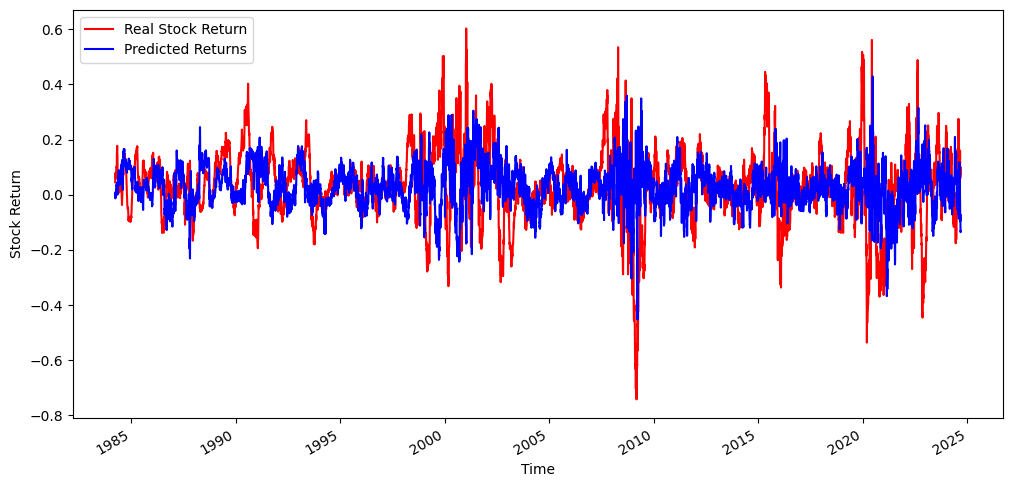

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df.plot(x="Date", y="Values", color="red", label="Real Stock Return", ax=ax)
df.plot(x="Date", y="Pred", color="blue", label="Predicted Returns", ax=ax)
plt.xlabel("Time")
plt.ylabel("Stock Return")
plt.legend()
plt.show()

In [37]:
df["Positions"] = df["Pred"].apply(np.sign)
df["Strat_ret"] = df["Positions"].shift(1) * df["Ret"]
df["Positions_L"] = df["Positions"].shift(1)
df["Positions_L"][df["Positions_L"] == -1] = 0
df["Strat_ret_L"] = df["Positions_L"] * df["Ret"]
df["CumRet"] = df["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["CumRet_L"] = df["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["bhRet"] = df["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

C:\Users\Asus\AppData\Local\Temp\ipykernel_8164\4012059038.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["Positions_L"][df["Positions_L"] == -1] = 0
C:\Users\Asus\AppData\Local\Temp\ipykernel_8164\4012059038.py:4: SettingWithCopyWar

Strat Return Long Only = 767.1202949320686 %
Strat Return = 6.526197852926785 %
Buy and Hold Return = 2352.017807519138 %


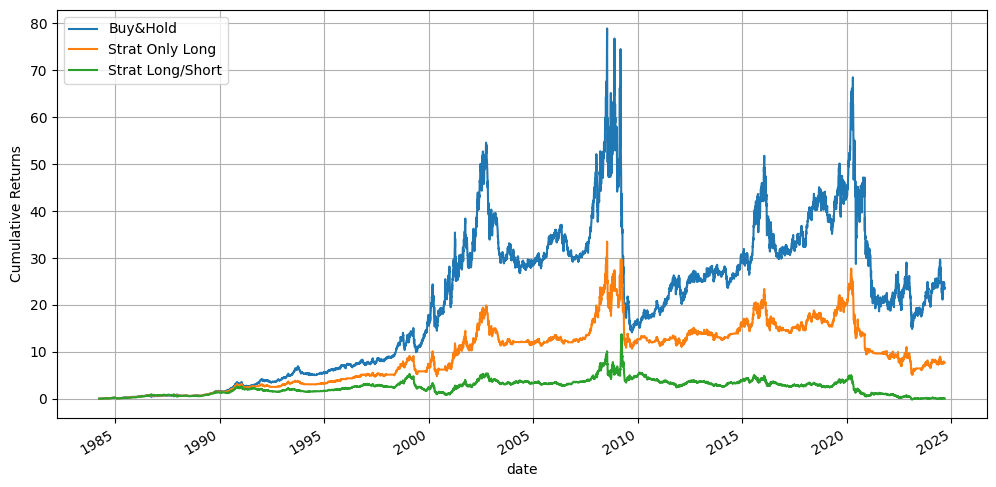

,Date,Pred,Ret,Values,Positions,Strat_ret,Positions_L,Strat_ret_L,CumRet,CumRet_L,bhRet
count,10192,10192.000000,10192.000000,10192.000000,10192.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10192.000000
mean,2004-06-08 13:50:29.199371904,0.027907,0.000460,0.028859,0.322802,0.000152,0.661466,0.000307,2.481531,9.249950,20.451675
min,1984-03-28 00:00:00,-0.452724,-0.205900,-0.742601,-1.000000,-0.205900,0.000000,-0.205900,-0.147747,-0.029430,-0.020557
25%,1994-04-25 18:00:00,-0.016784,-0.005900,-0.030970,-1.000000,-0.006300,0.000000,-0.001700,1.251247,3.283363,5.406691
50%,2004-06-07 12:00:00,0.026968,0.001000,0.030406,1.000000,0.000600,1.000000,0.000000,2.637166,9.681035,21.150734
75%,2014-07-22 06:00:00,0.075317,0.007400,0.094711,1.000000,0.007100,1.000000,0.003900,3.458433,13.640695,30.928740
max,2024-09-05 00:00:00,0.429347,0.143300,0.603302,1.000000,0.170900,1.000000,0.143300,13.755100,33.470085,78.932222
std,NaN,0.075105,0.017012,0.131528,0.946513,0.017019,0.473234,0.013662,1.567605,6.279766,15.311439


In [38]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.show()

df.describe()